In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize, integrate, stats
import time
import ROOT

Welcome to JupyROOT 6.24/06


# Create the PDF
You only need to this once, so it's commented.

In [2]:
#ROOT.RooClassFactory.makePdf("AngularDistribution", "ctheta,phi,sx,sz,alpha", "",
#                             "1+ alpha * (sx * sqrt(1-pow(ctheta,2)) * cos(phi) + sz * ctheta)"
#                            )

# Load the PDF

In [3]:
ROOT.gSystem.Load('libAngularDistribution.so')

0


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



# Unconvoluted PDF

In [4]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [5]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [6]:
def sx(g: float) -> float:
    sz = 1
    Dy = 4
    beta = 1
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    return - sz * np.sin(Phi_rot)

def sz(g: float) -> float:
    sz = 1
    Dy = 4
    beta = 1
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    return sz * np.cos(Phi_rot)

In [7]:
g = 1.226

ctheta = ROOT.RooRealVar("ctheta", "ctheta", 0., -1., 1.)
phi = ROOT.RooRealVar("phi", "phi", 0., -np.pi, np.pi)
alpha = ROOT.RooFit.RooConst(0.732)
sx = ROOT.RooFit.RooConst(sx(g))
sz = ROOT.RooFit.RooConst(sz(g))

In [8]:
angular_pdf = ROOT.AngularDistribution("pdf", "pdf", ctheta, phi, sx, sz, alpha)

In [9]:
angular_pdf.evaluate()

0.551977425457729

In [10]:
data_noconv = angular_pdf.generate(ROOT.RooArgSet(ctheta, phi), 100000)
data_noconv.write("unconvoluted_test.dat")
df_noconv = pd.read_csv('unconvoluted_test.dat', sep=" ", header=None)
df_noconv.drop(columns=[2], inplace=True)
df_noconv.rename(columns={0: 'cos_theta', 1: 'phi'}, inplace=True)

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta,phi]) using numeric integrator RooAdaptiveIntegratorND to calculate Int(ctheta,phi)
[#1] INFO:DataHandling -- RooDataSet::write(pdfData) writing ASCII file unconvoluted_test.dat


In [11]:
df_noconv

,cos_theta,phi
0,-0.092542,-1.748670
1,0.786748,1.515830
2,0.097034,-2.604970
3,-0.504857,-1.772200
4,0.826671,-1.061240
...,...,...
99995,-0.700661,0.933466
99996,0.723367,1.805950
99997,-0.509533,1.967210
99998,0.472264,2.378940


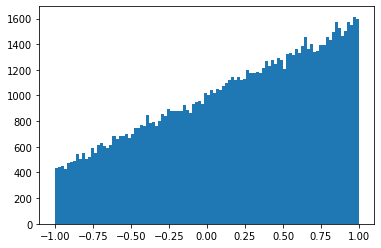

In [12]:
plt.hist(df_noconv['cos_theta'],bins=100)
plt.show()

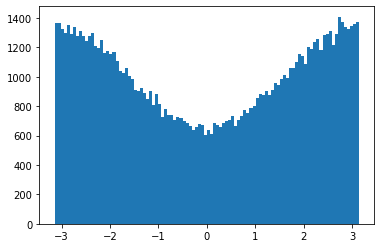

In [13]:
plt.hist(df_noconv['phi'],bins=100)
plt.show()

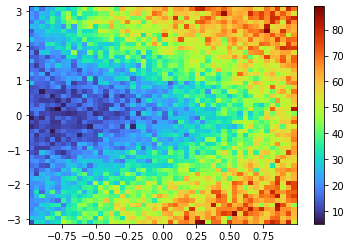

In [14]:
plt.hist2d(df_noconv['cos_theta'], df_noconv['phi'],bins=50, cmap='turbo')
plt.colorbar()
plt.show()

# $\theta$-convoluted PDF

In [15]:
theta_resolution = 0.097

In [16]:
sigma_theta = ROOT.RooFit.RooConst(theta_resolution)
mu_theta = ROOT.RooFit.RooConst(0.)

In [17]:
gaussian_theta = ROOT.RooGaussian("gaussian_theta", "gaussian_theta", ctheta, mu_theta, sigma_theta)

In [18]:
pdf_theta_conv = ROOT.RooFFTConvPdf("pdf_theta_conv", "pdf_theta_conv", ctheta, angular_pdf, gaussian_theta)

[#1] INFO:Caching -- Changing internal binning of variable 'ctheta' in FFT 'pdf_theta_conv' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [19]:
pdf_theta_conv.bufferFraction()

0.1

In [20]:
#pdf_theta_conv.setBufferFraction(0.)
#pdf_theta_conv.bufferFraction()

In [21]:
pdf_theta_conv.bufferStrategy()

0

In [22]:
pdf_theta_conv.setBufferStrategy(2)
pdf_theta_conv.bufferStrategy()

2

In [23]:
tick = time.perf_counter()
data_theta_conv = pdf_theta_conv.generate(ROOT.RooArgSet(ctheta, phi), 100000)
tock = time.perf_counter()
print(tock - tick)
#data_theta_conv = pdf_theta_conv.generate(ctheta, 10000)

114.23363057523966
[#1] INFO:Eval -- RooRealVar::setRange(ctheta) new range named 'refrange_fft_pdf_theta_conv' created with bounds [-1,1]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta]) using numeric integrator RooIntegrator1D to calculate Int(ctheta)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_conv) creating new cache 0x97eb6f0 with pdf pdf_CONV_gaussian_theta_CACHE_Obs[ctheta]_NORM_ctheta_phi for nset (ctheta,phi) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_CONV_gaussian_theta_CACHE_Obs[ctheta]_NORM_ctheta_phi_Int[ctheta,phi]) using numeric integrator RooIntegrator1D to calculate Int(phi)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[ctheta]) using numeric integrator RooIntegrator1D to calculate Int(ctheta)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_conv) creating new cache 0x9a32b30 with pdf pdf_CONV_gaussian_theta_CACHE_Obs[ctheta]_NORM_ctheta_phi for nset (ctheta,phi) with code 0
[#1] INFO

In [24]:
data_theta_conv.write("theta_conv_test.dat")
df_theta_conv = pd.read_csv('theta_conv_test.dat', sep=" ", header=None)
df_theta_conv.drop(columns=[2], inplace=True)
df_theta_conv.rename(columns={0: 'cos_theta', 1: 'phi'}, inplace=True)

[#1] INFO:DataHandling -- RooDataSet::write(pdf_theta_convData) writing ASCII file theta_conv_test.dat


In [25]:
df_theta_conv

,cos_theta,phi
0,0.953940,-3.132340
1,-0.720874,-1.996080
2,0.859159,2.362570
3,0.755553,0.854252
4,0.832146,1.148780
...,...,...
99995,0.407353,3.115730
99996,0.226729,2.603730
99997,-0.756814,-3.029030
99998,-0.394159,-2.418790


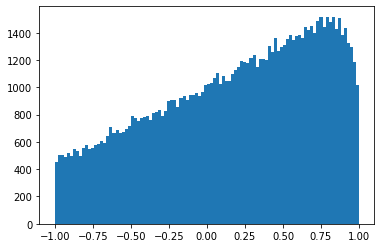

In [26]:
plt.hist(df_theta_conv['cos_theta'],bins=100)
plt.show()

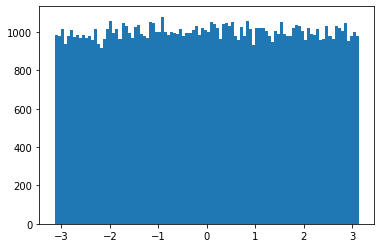

In [27]:
plt.hist(df_theta_conv['phi'],bins=100)
plt.show()

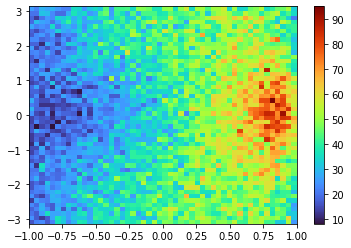

In [28]:
plt.hist2d(df_theta_conv['cos_theta'], df_theta_conv['phi'],bins=50, cmap='turbo')
plt.xlim(-1,1)
plt.ylim(-np.pi,np.pi)
plt.colorbar()
plt.show()

# $\theta$- and $\phi$-convoluted PDF

In [29]:
phi_resolution = 0.332

In [30]:
sigma_phi = ROOT.RooFit.RooConst(phi_resolution)
mu_phi = ROOT.RooFit.RooConst(0.)

In [31]:
gaussian_phi = ROOT.RooGaussian("gaussian_phi", "gaussian_phi", phi, mu_phi, sigma_phi)

In [32]:
pdf_theta_phi_conv = ROOT.RooFFTConvPdf("pdf_theta_phi_conv", "pdf_theta_phi_conv", phi, pdf_theta_conv, gaussian_phi)

[#1] INFO:Caching -- Changing internal binning of variable 'phi' in FFT 'pdf_theta_phi_conv' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [33]:
pdf_theta_phi_conv.setBufferStrategy(2)

In [34]:
tick = time.perf_counter()
data_theta_phi_conv = pdf_theta_phi_conv.generate(ROOT.RooArgSet(ctheta, phi), 100000)
tock = time.perf_counter()
print(tock - tick)

3361.037749812007
[#1] INFO:Eval -- RooRealVar::setRange(phi) new range named 'refrange_fft_pdf_theta_phi_conv' created with bounds [-3.14159,3.14159]
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_conv) creating new cache 0x9fddd00 with pdf pdf_CONV_gaussian_theta_CACHE_Obs[phi,ctheta]_NORM_phi for nset (phi) with code 0
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_phi_conv) creating new cache 0x9fc9a00 with pdf pdf_theta_conv_CONV_gaussian_phi_CACHE_Obs[phi]_NORM_ctheta_phi for nset (ctheta,phi) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_theta_conv_CONV_gaussian_phi_CACHE_Obs[phi]_NORM_ctheta_phi_Int[ctheta,phi]) using numeric integrator RooIntegrator1D to calculate Int(ctheta)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_theta_conv) creating new cache 0xcf015b0 with pdf pdf_CONV_gaussian_theta_CACHE_Obs[phi,ctheta]_NORM_phi for nset (phi) with code 0 from preexisting content.
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(pdf_th

In [35]:
data_theta_phi_conv.write("theta_phi_conv_test.dat")
df_theta_phi_conv = pd.read_csv('theta_phi_conv_test.dat', sep=" ", header=None)
df_theta_phi_conv.drop(columns=[2], inplace=True)
df_theta_phi_conv.rename(columns={0: 'cos_theta', 1: 'phi'}, inplace=True)

[#1] INFO:DataHandling -- RooDataSet::write(pdf_theta_phi_convData) writing ASCII file theta_phi_conv_test.dat


In [36]:
df_theta_phi_conv

,cos_theta,phi
0,0.827647,2.465840
1,-0.297857,2.081670
2,0.611567,1.226110
3,0.902566,0.141068
4,-0.602676,-2.895740
...,...,...
99995,-0.462799,2.414960
99996,-0.162771,-2.897930
99997,0.921845,2.522090
99998,-0.004698,1.253690


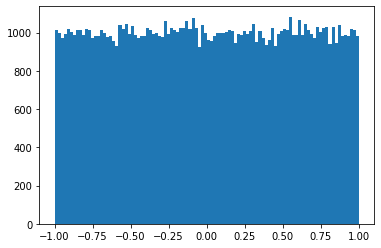

In [37]:
plt.hist(df_theta_phi_conv['cos_theta'],bins=100)
plt.show()

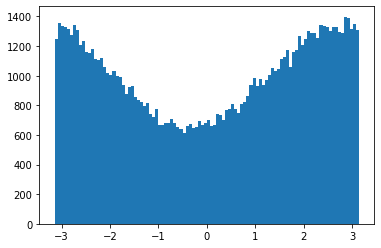

In [38]:
plt.hist(df_theta_phi_conv['phi'],bins=100)
plt.show()

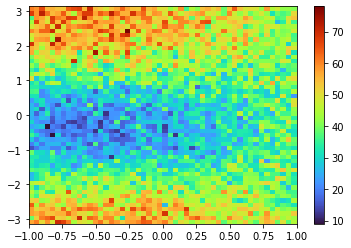

In [39]:
plt.hist2d(df_theta_phi_conv['cos_theta'], df_theta_phi_conv['phi'],bins=50, cmap='turbo')
plt.xlim(-1,1)
plt.ylim(-np.pi,np.pi)
plt.colorbar()
plt.show()

This finds the value in 1D.

In [ ]:
#xframe = ctheta.frame()

In [ ]:
#theta_convoluted.plotOn(xframe, ROOT.RooFit.Name("theta_convoluted"))

In [ ]:
#func = xframe.findObject("theta_convoluted")

In [ ]:
#func.Eval(0.)